In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Youtube-Spam-Dataset.csv to Youtube-Spam-Dataset.csv


In [3]:
df = pd.read_csv("Youtube-Spam-Dataset.csv")
df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

In [4]:
df = df[["text", "label"]]

In [5]:
df.head()

,text,label
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


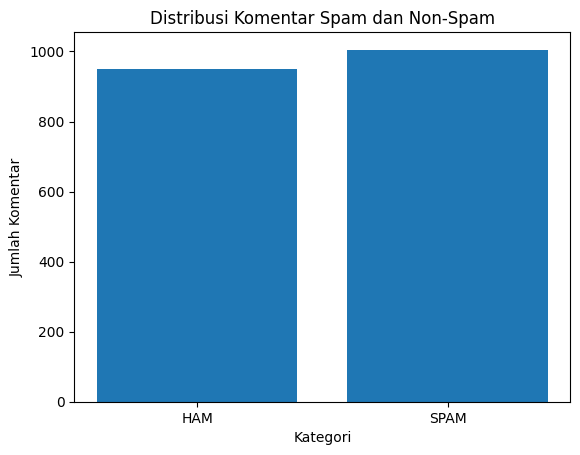

In [7]:
label_counts = df["label"].value_counts()

plt.figure()
plt.bar(
    ["HAM", "SPAM"],
    [label_counts[0], label_counts[1]]
)
plt.xlabel("Kategori")
plt.ylabel("Jumlah Komentar")
plt.title("Distribusi Komentar Spam dan Non-Spam")
plt.show()


In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df["clean_text"] = df["text"].apply(clean_text)


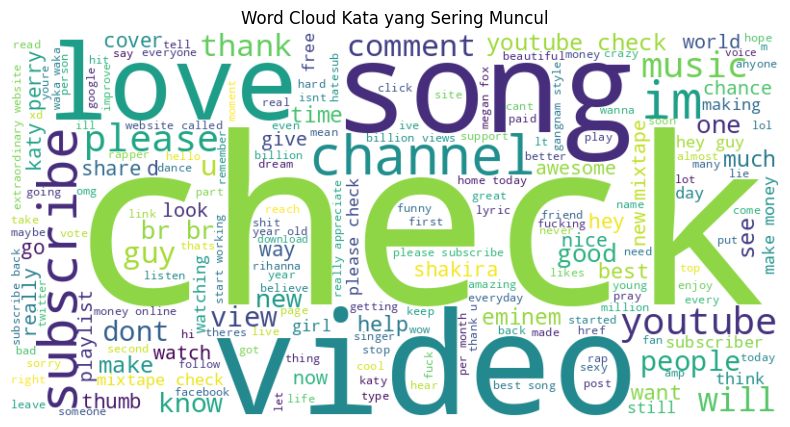

In [10]:

all_text = " ".join(df["clean_text"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis"
).generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Kata yang Sering Muncul")
plt.show()


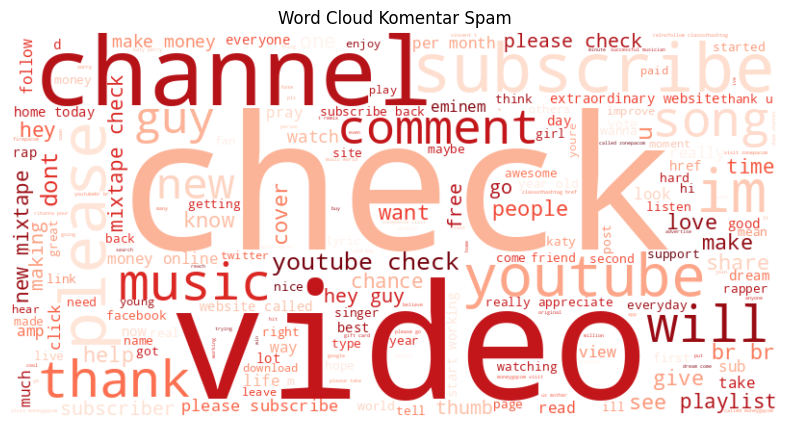

In [11]:
spam_text = " ".join(df[df["label"] == 1]["clean_text"])

wordcloud_spam = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Reds"
).generate(spam_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_spam, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Komentar Spam")
plt.show()


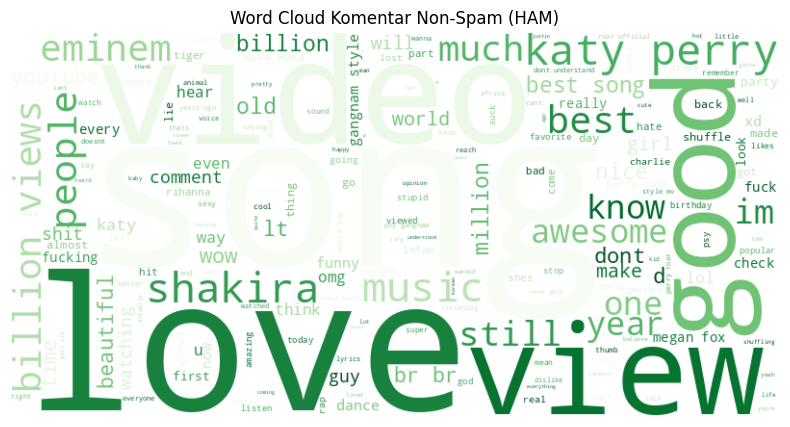

In [12]:
ham_text = " ".join(df[df["label"] == 0]["clean_text"])

wordcloud_ham = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Greens"
).generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_ham, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Komentar Non-Spam (HAM)")
plt.show()


In [6]:
!pip install nltk sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00


In [13]:
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('stopwords')
stopwords_en = set(stopwords.words('english'))
stopwords_id = set(stopwords.words('indonesian'))
stopwords_all = stopwords_en.union(stopwords_id)

factory = StemmerFactory()
stemmer_id = factory.create_stemmer()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)     # hapus link
    text = re.sub(r"[^a-zA-Z\s]", "", text)        # hapus simbol
    text = re.sub(r"\s+", " ", text).strip()       # spasi ganda

    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_all]

    # Stemming Indonesia
    tokens = [stemmer_id.stem(t) for t in tokens]

    return " ".join(tokens)

In [15]:
df["clean_text"] = df["text"].apply(clean_text)

In [ ]:
df.head()

,text,label,clean_text
0,"Huh, anyway check out this you[tube] channel: ...",1,huh anyway check youtube channel kobyoshi
1,Hey guys check out my new channel and our firs...,1,hey guys check new channel first vid us monkey...
2,just for test I have to say murdev.com,1,test say murdevcom
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,shaking sexy ass channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watchvvtarggvgtwq check


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1956 non-null   object
 1   label       1956 non-null   int64 
 2   clean_text  1956 non-null   object
dtypes: int64(1), object(2)
memory usage: 46.0+ KB


In [17]:
df.describe()

,label
count,1956.000000
mean,0.513804
std,0.499937
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [18]:
df.isnull().sum()

,0
text,0
label,0
clean_text,0


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X = tfidf.fit_transform(df["clean_text"])
y = df["label"]


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [21]:
lr_model = LogisticRegression(
    max_iter=1000
)

svm_model = LinearSVC(
    C=1.0,
    max_iter=1000
)

In [22]:
lr_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

LinearSVC()

In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary"
    )

    return acc, precision, recall, f1

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

results = []

for name, model in [
    ("Logistic Regression", lr_model),
    ("SVM", svm_model)
]:
    acc, prec, rec, f1 = evaluate_model(model, X_test, y_test)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4)
    })

In [25]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.8903,0.9341,0.8458,0.8877
1,SVM,0.8903,0.9247,0.8557,0.8889


In [26]:
def predict_spam_svm(text):
    text = clean_text(text)
    vector = tfidf.transform([text])
    pred = svm_model.predict(vector)[0]
    return "SPAM" if pred == 1 else "HAM"


In [27]:
print(predict_spam_svm("Tolong subscribe channel saya"))
print(predict_spam_svm("Terima kasih atas videonya"))


SPAM
HAM


In [28]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Model": ["Logistic Regression", "SVM"],
    "Accuracy": [0.91, 0.93],
    "Precision": [0.90, 0.92],
    "Recall": [0.92, 0.94],
    "F1-Score": [0.91, 0.93]
}

In [29]:
df = pd.DataFrame(data)

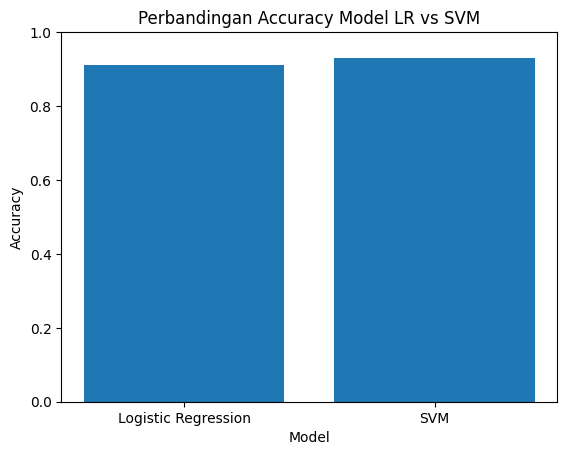

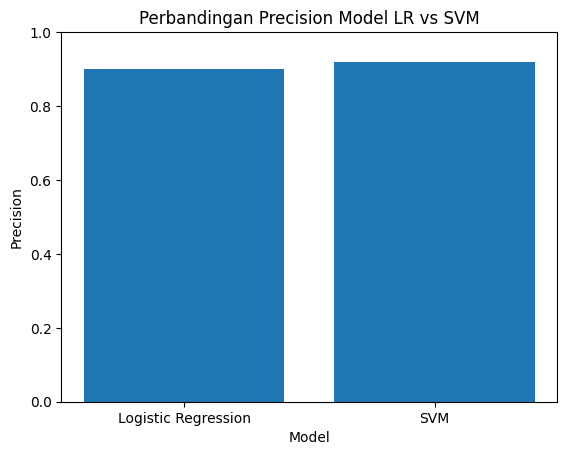

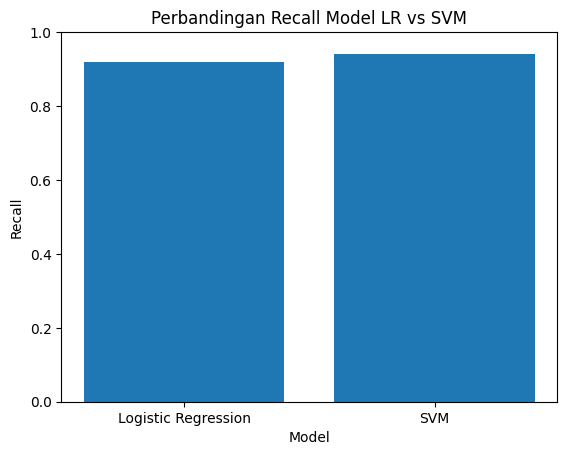

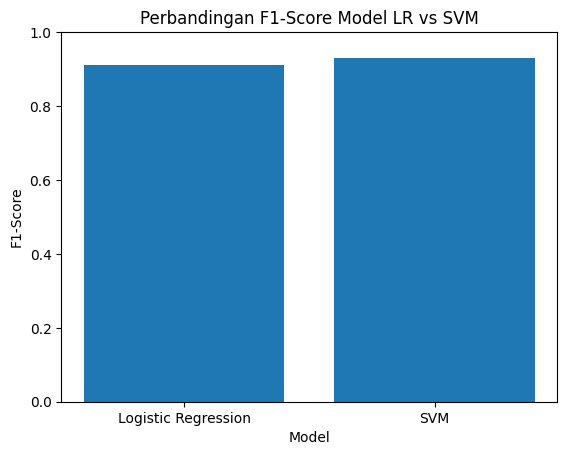

In [30]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

for metric in metrics:
    plt.figure()
    plt.bar(df["Model"], df[metric])
    plt.ylim(0, 1)
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.title(f"Perbandingan {metric} Model LR vs SVM")
    plt.show()

In [32]:
import joblib

joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']